# Práctica 4
## Clasificación de imágenes de perros y gatos empleando técnicas de Deep Learning

### Introducción 

El objetivo de esta práctica es establecer un primer contacto con el mundo de las redes neuronales y el Deep Learning, en concreto en el ámbito de la Visión por Computador. Para tal fin se propone construir una red neuronal capaz de clasificar imágenes de perros y gatos. 

Para la realización de la práctica se empleará la API Keras de TensorFlow, una herramienta muy utilizada actualmente. Además se va ha hacer uso de la plataforma Google Colaboratory, que permite, entre otras cosas, hacer uso gratuito de potentes GPU en servidores remotos. Así pues, esta práctica tambien sirve como una primera toma de contacto con estas conocidas y útiles herramientas. 

### Datos

En este práctica se hará uso de un dataset que contiene un total de 3000 imágenes de perros y gatos de diferentes tamaños. Este dataset ya se proporciona con la organización de directorios apropiada para este ejercicio: 


*   Cat_dog_filtered -> directorio padre
  *   Train -> conjunto de entrenamiento
      * Cats -> Clase de gatos
      * Dogs -> Clase de perros
  * Valdiation -> Conjunto de validación
      * Cats -> Clase de gatos
      * Dogs -> Clase de perros

#### Data augmentation 

La técnica del _data augmentation_ permite aumentar el conjunto de datos de datos original. En particular, permite crear nuevas imágenes aplicando transformaciones geométricas sobre las existente, generando así nuevas imágenes realistas para entrenar el modelo. Esta técnica nos permite evitar el _overfitting_ del modelo cuando no se dispone de un conjunto muy grande de datos, lo cual puede derivar en el modelado del ruido presente en estos. 



## Comienzo de la práctica

Primero de todo se importan todas aquellas librerías necesarias para el desarrollo de la práctica. De Keras, nos interesa la librería _layers_, la cual permite instanciar objetos a modo de diferentes capas de la red neuronal, y _Sequential_, que será el modelo a emplear en esta práctica. Este modelo es apropiado cuando se busca una red construida por una secuencia de capas, donde cada una recibe con entrada un solo tensor y tiene como salida otro tensor. 

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

A continuación confirmamos que nos podemos conectar a una GPU con TensorFlow. 

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Bien, parece que existe una conexión.

Se definen algunos parámetros importantes para el desarrollo de la práctica: 


*   _Batch size_ : tamaño del _batch_ de imágenes que se leerá cada vez del disco. 
*   _img_height_ y _img_width_ : tamaño de la imagen leída. Si una imagen del conjunto no coincide con este tamaño, se transforma a dichas dimensiones. 



In [ ]:
batch_size = 25 #adecuado para el problema
img_height = 256
img_width = 256

#### Data augmentation

A continuación se crean los objetos que van a permitir coger _batches_ de imágenes desde disco y generar artificialmente nuevas en tiempo real. Este objeto es el _ImageDatagenerator_ de Keras. En su constructor, permite definir una serie de parámetros a utilizar en la generación de imágenes, como el ángulo máximo de rotación (_rotation range_) o la fracción total de zoom (_zoom range_).

Se definen así los generadores de imágenes para el conjunto de entrenamiento (_train_datagen_) y validación (_val_datagen_).

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    rotation_range = 90,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    rotation_range = 90,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2
) 

Se definen los directorios donde residen las imágenes buscadas. El argumento _class mode_ permite etiquetar automáticamente de forma binaria las imágenes pertenecientes a las dos clases: perros y gatos dividos en directorios separados. Esta infromación se almacena en el objeto _train_generator_ y _validation_generator_, que se emplearán posteriormente cuando se entrene el modelo. Serán los encargados de leer imágenes de disco y aplicar en tiempo real el _data augmentation_. 

Una gran ventaja de emplear estos generadores en la práctica es que no es necesario que el conjunto entero de datos quepa en memoria RAM, lo cual es poco realista en la moyoría de problemas. Esto es así ya que durante el entrenamiento del modelo se van cargando _batches_ de tamaño reducido desde disco y no se carga el dataset entero. Cada _batch_ se emplea para realizar un paso en el descenso del gradiente. Cuando se ha completado, se carga otro _batch_ y se realiza lo mismo. 

In [ ]:
train_generator = train_datagen.flow_from_directory('./drive/MyDrive/DP_Vision/in/cat_and_dog_filtered/train',
                                                    target_size = (img_height,img_width),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary')

validation_generator = val_datagen.flow_from_directory('./drive/MyDrive/DP_Vision/in/cat_and_dog_filtered/validation',
                                                    target_size = (img_height,img_width),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Por salida estándar se nos muestra el número de imágenes de entrenamiento y validación encontradas y el número de clases total en ambos grupos. En este caso 2 clases, perros y gatos. 

#### Modelo 1

Se define la arquitectura del primer modelo. Lo primero de todo es la capa de entrada, en la cual definimos el tamaño de las imágenes. En este caso, al ser imágenes RGB se debe poner un 3 en la tercera dimensión (número de canales). Posteriormente se alternan capas de convolución y capas de _max pooling_. Las capas de _max pooling_ ayudan a reducir la dimensionalidad de las capas de convolución extrayendo el valor máximo de cada paso del filtro por la imagen. Además permiten cada vez más identificar carácterísticas de más alto nivel a medida que se hace más profunda la red. Finalmente se aplana a una sola dimensión el resultado de las capas de convolución, de tal manera que se dispone la información en el formato adecuado para introducirlo en un perceptrón multicapa. Este estrá compuesto por una capa oculta de 128 neuronas y una capa de salida que emplea la función _softmax_ para generar una salida con valores entre 0 y 1, tal que la suma de las salidas sea 1. Así se consigue una distribución de probabilidad de la pertenencia de una observación (imagen) a cada clase. 

La diferencia entre este modelo y el siguiente es la función de activación y de coste, como se verá más adelante. 

In [ ]:
model = Sequential([
  layers.InputLayer(input_shape=(img_height,img_width,3)),
  layers.Conv2D(10, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(20, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(40, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2,activation='softmax') # 2 classes
])

A continuación se defininen la función de pérdida a optimizar, así como la métrica a evaluar durante el entrenamiento. Como función de pérdida se escoge la _sparse categorical cross entropy_, que según la documentación oficial, es válida únicamente cuando se disponen de dos o más salidas en forma de distribución de probabilidad. La métrica escogida es el _accuracy_. 

También se podría seleccionar el método de optimización de la función de coste. En este caso se escoge el de por defecto, el algoritmo RMSprop. 

In [ ]:
model.compile(#optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

La función _summary_ nos permite ver de forma esquemática la arquitectura de la red creada.

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 256, 256, 10)      280       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 128, 128, 10)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 128, 20)      1820      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 64, 64, 40)        7240      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 32, 32, 40)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 40960)           

Finalmente se procede a entrenar el modelo. Se hace uso de la función _fit_generator_, que nos permite entrenar el modelo haciendo uso de los generadores creados tanto para el conjunto de entrenamiento como validación. El arguemento _steps_per_epoch_ permite establecer el número de pasos de descenso del gradiente a realizar por _epoch_. Es decir, el número de _batches_ por _epoch_. En este caso, para asegurar que no se excede el número de imágenes disponibles (lo cual ha sucedido), este argumento se inicializa al número de _batches_ máximo que encaja con las imágenes que se tienen. 

En un principio el número de _batches_ se inicializó a 32 y los pasos por _epoch_ a 100, lo cual supone un total de 3200 imágenes. Esto hacía saltar un error que daba entender que se paraba el entrenamiento por insuficiencia de _inputs_. Así que se modificó a los valores actuales. 

In [ ]:
history = model.fit_generator (
    train_generator, 
    steps_per_epoch = 2000/batch_size,
    epochs = 100, 
    validation_data = validation_generator,
    validation_steps=1000/batch_size
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
80/80 [==============================] - 48s 595ms/step - loss: 212.7686 - accuracy: 0.5028 - val_loss: 0.6928 - val_accuracy: 0.5810
Epoch 2/100
80/80 [==============================] - 46s 581ms/step - loss: 0.7317 - accuracy: 0.5615 - val_loss: 0.6864 - val_accuracy: 0.5650
Epoch 3/100
80/80 [==============================] - 46s 578ms/step - loss: 0.7147 - accuracy: 0.5540 - val_loss: 0.6876 - val_accuracy: 0.5700
Epoch 4/100
80/80 [==============================] - 46s 576ms/step - loss: 0.7021 - accuracy: 0.5568 - val_loss: 0.7001 - val_accuracy: 0.5390
Epoch 5/100
80/80 [==============================] - 46s 577ms/step - loss: 0.7108 - accuracy: 0.5722 - val_loss: 0.6642 - val_accuracy: 0.5850
Epoch 6/100
80/80 [==============================] - 46s 575ms/step - loss: 0.7028 - accuracy: 0.5855 - val_loss: 0.6917 - val_accuracy: 0.5580
Epoch 7/100
80/80 [==============================] - 46s 581ms/step - loss: 0.7110 - accuracy: 0.5877 - val_loss: 0.6974 - val_accurac

A continuación se realizan unas gráficas que permiten observas la evolución del _accuracy_ y el valor de la función de coste a cada _epoch_ del entrenamiento y por cada conjunto de imágenes (entrenamiento y validación). 

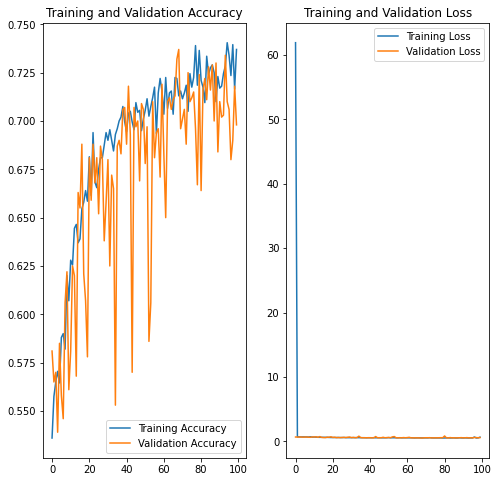

In [ ]:
epochs = 100

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Lo primero a comentar es que el entrenamiento del modelo parece ir bien: a cuantas más _epochs_, menor error en la clasificación. Así que el proceso de aprendizaje está asegurado. Por otro lado, el _accuracy_ del entrenamiento y el de validación son similares en cada _epoch_, por lo que no existen indicio de _overfitting_. Si que se observan algunas _epochs_ en lo que existe una mayor diferencia entre entrenamiento y validación, pero son casos puntuales y no mayor a 0.2. Por el contrario, un ejemplo de _overfitting_ sería aquel en el que el _accuracy_ del entrenamiento crece a medida que se hacen más _epochs_, mientras que el de la validación se mantiene casi constante a partir de un cierto punto. Esto indicaría un aprendizaje demasiado exacto del conjunto de entrenamiento y, por lo tanto, mala generalización a nuevas observaciones. 

En la segunda gráfica se contempla como el error a partir de la primera _epoch_ desciende a valores muy cercano a 0 en el conjunto de entrenamiento. Dicho descenso no ocurre en la validación ya que en el momento de evaluar la función de coste con este grupo, los pesos ya estan actualizados y, por lo tanto, se producen mejores resultados que al principio con una inicialización aleatoria de los pesos. 

#### Modelo 2

En este segundo modelo se toma como función de activación de la útima capa la función sigmoide. Esta función dará la probabilidad de que una imagen pertenezca a la clase 1 (perros, en este caso). Por lo tanto, en la última capa solo se dispondrá de 1 neurona, a diferencia de las dos neuronas del modelo 1 que ofrecían las probabilidaded de que una imagen fuese perro o gato, cuya suma era igual a 1. Si se pusiesen dos neuronas con una función de activación sigmoidal, darían dos probabilidades independientes, lo cual resulta difícil de interpretar y posiblemente no sea correcto para el entrenamiento de la red. 

La arquitecutra de esta red es idéntica a la del modelo 1 con tal de poder establecer una comparación valida posteriormente. 

In [ ]:
model_2 = Sequential([
  layers.InputLayer(input_shape=(img_height,img_width,3)),
  layers.Conv2D(10, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(20, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(40, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1,activation='sigmoid') 
])

En este caso, al no disponerse de dos o más salidas en forma de distribución de probabilidad, la función de coste _sparse categorical cross entropy_ no es adecuada para el entrenamiento. Por ese motivo se hace uso de _binary cross entropy_. 

Tanto la métrica como el método de optimización se mantienen iguales al modelo 1.

In [ ]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 256, 256, 10)      280       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 128, 128, 10)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 128, 128, 20)      1820      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 40)        7240      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 32, 32, 40)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 40960)           

Se entrena el modelo con las mismas _epochs_ y _steps_per_epoch_.

In [ ]:
history_2 = model_2.fit_generator (
    train_generator, 
    steps_per_epoch = 2000/batch_size,
    epochs = 100, 
    validation_data = validation_generator,
    validation_steps=1000/batch_size
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
80/80 [==============================] - 47s 582ms/step - loss: 452.0248 - accuracy: 0.4988 - val_loss: 0.7108 - val_accuracy: 0.5210
Epoch 2/100
80/80 [==============================] - 46s 582ms/step - loss: 0.7463 - accuracy: 0.5034 - val_loss: 0.8171 - val_accuracy: 0.5020
Epoch 3/100
80/80 [==============================] - 46s 576ms/step - loss: 1.0355 - accuracy: 0.5462 - val_loss: 0.6808 - val_accuracy: 0.5650
Epoch 4/100
80/80 [==============================] - 46s 576ms/step - loss: 0.7667 - accuracy: 0.5448 - val_loss: 0.6808 - val_accuracy: 0.5540
Epoch 5/100
80/80 [==============================] - 46s 574ms/step - loss: 0.7024 - accuracy: 0.5571 - val_loss: 0.6876 - val_accuracy: 0.5400
Epoch 6/100
80/80 [==============================] - 46s 576ms/step - loss: 0.7433 - accuracy: 0.5567 - val_loss: 0.6802 - val_accuracy: 0.5610
Epoch 7/100
80/80 [==============================] - 46s 577ms/step - loss: 0.6741 - accuracy: 0.5571 - val_loss: 0.7002 - val_accurac

Se realizan las mismas gráficas de los valores del _accuracy_ y la función de coste. 

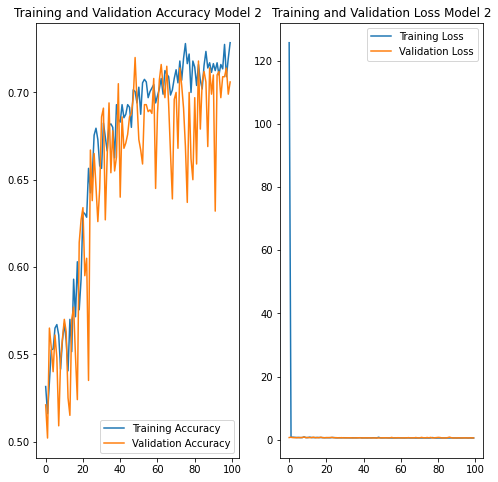

In [ ]:
epochs_2 = 100

acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']

loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range_2 = range(epochs_2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_2, acc_2, label='Training Accuracy')
plt.plot(epochs_range_2, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Model 2')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_2, loss_2, label='Training Loss')
plt.plot(epochs_range_2, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Model 2')
plt.show()

A simple vista cuesta decidir que modelo funciona mejor observando las gráficas de ambos modelos. 

En cuanto al _accuracy_, este modelo 2 parece mantener una mayor armonía en los valores de entrenamiento y validación, no aparecen diferencias puntuales que destaquen a diferencia de lo que pasaba en el modelo 1. 

Por otro lado el valor del error, con las gráficas disponibles, parece bastante similar. No obstante, si se observan los valores numéricos que se ofrecen por la salida estándar durante el entrenamiento, se comprueba que el modelo 1 llega a valores un poco más bajos (en torno al 0.55-0.6) que el modelo 2 (en torno el 0.6-0.65).

A continuación se plantean una serie de gráficas que ayudan a realizar una mejor comparación y selección del mejor modelo. 

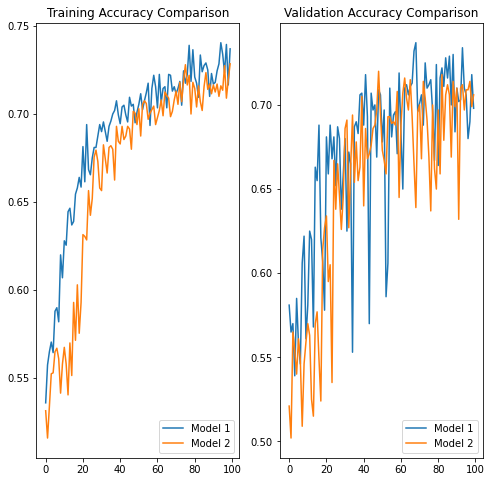

In [ ]:
epochs = 100
epoch_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Model 1')
plt.plot(epochs_range, acc_2, label='Model 2')
plt.legend(loc='lower right')
plt.title('Training Accuracy Comparison')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_acc, label='Model 1')
plt.plot(epochs_range, val_acc_2, label='Model 2')
plt.legend(loc='lower right')
plt.title('Validation Accuracy Comparison')
plt.show()

Como puede apreciarse, si solo se fija el punto de mira en el grupo de entrenamiento el modelo 1 obtiene mejor _accuracy_ que el modelo 2 en todo momento, especialmente al principio del entrenamiento. Sin embargo este _accuracy_ no es tan relevante como el de validación, donde si que queda expuesta la capacidad de generalización del modelo. En este segundo _accuracy_, ambos modelos presentan un progreso parecido. Sin embargo, si tuviese que elegir uno, sería el modelo 1, el cual se impone al modelo 2 tanto al principio como al final del modelo en términos de _accuracy_, a pesar de presentar algunos valles puntuales (ya se ha comentado que no son de gran importancia). 

Finalmente se realizan unas gráficas del valor de la función de coste que permitan observar con mayor claridad los valores adquiridos por ambos modelos durante el entrenamiento. 

Text(0.5, 1.0, 'Validation Loss Values Comparison')

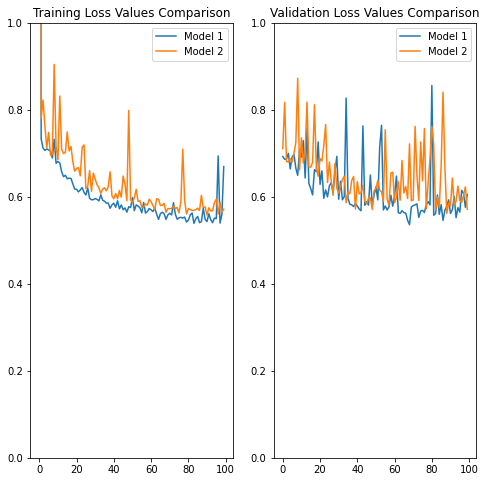

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epoch_range, loss, label = 'Model 1')
plt.plot(epoch_range, loss_2, label = 'Model 2')
plt.ylim([0,1])
plt.legend(loc='upper right')
plt.title('Training Loss Values Comparison')

plt.subplot(1,2,2)
plt.plot(epoch_range, val_loss, label = 'Model 1')
plt.plot(epoch_range, val_loss_2, label = 'Model 2')
plt.ylim([0,1])
plt.legend(loc='upper right')
plt.title('Validation Loss Values Comparison')

De nuevo, en cuanto al conjunto de entrenamiento, el modelo 1 parece tener en todo momento un valor de la función de coste menor al modelo 2. En cuanto al conjunto de validación, esto parece ser cierto también, aunque de una forma menos explícita. Son aspectos que también se han observado en las gráficas del accuracy, pero como es lógico, esta similitud tenía que existir. 

Sin embargo, esta comparación de funciones de coste puede no ser válida ya que las funciones de coste son distintas, y por lo tanto el error puede estar en escalas distintas. Ambas funciones deben tener sus mínimos en 0, ya que sino sería imposible de partida obtener un error 0, y por lo tanto una clasificación perfecta (aunque eso suena idealista), pero para una misma diferencia entre la salida deseada y la obtenida, el error puede ser distinto depende de la función usada. 